# Intent Detection 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments,TextClassificationPipeline)

RANDOM_SEED = 34

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [2]:
# Log in to Wandb for reporting
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: subhasisj (use `wandb login --relogin` to force relogin)


True

In [3]:
t1 = torch.randn(1,2)
t2 = torch.randn(1,2).to(device)
print(t1)  # tensor([[-0.2678,  1.9252]])
print(t2)  # tensor([[ 0.5117, -3.6247]], device='cuda:0')

tensor([[ 0.8934, -1.2830]])
tensor([[1.2826, 0.4020]], device='cuda:0')


In [4]:
clinc = load_dataset("clinc_oos","plus")
clinc

Reusing dataset clinc_oos (C:\Users\Subha\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [5]:
clinc["train"][10]

{'intent': 61, 'text': "how would i say, 'i don't know the answer' in spanish"}

In [6]:
# Here intents are provided as ID's can be converted string
intents = clinc["train"].features["intent"]

In [7]:
intents.int2str(clinc["train"][10]["intent"])

'translate'

In [8]:
train_dataset = clinc['train']
val_dataset = clinc['validation']
test_dataset = clinc['test']

In [9]:
train_dataset

Dataset({
    features: ['text', 'intent'],
    num_rows: 15250
})

In [10]:
train_dataset.column_names

['intent', 'text']

In [11]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'intent': ClassLabel(num_classes=151, names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_f

## Convert Dataset to Dataframe

In [12]:
clinc.set_format(type='pandas')
df = clinc["train"][:]
df.head()

,intent,text
0,61,what expression would i use to say i love you ...
1,61,can you tell me how to say 'i do not speak muc...
2,61,"what is the equivalent of, 'life is good' in f..."
3,61,"tell me how to say, 'it is a beautiful morning..."
4,61,"if i were mongolian, how would i say that i am..."


In [13]:
# convert int2str for all intents
def label_int2str(row,split):
    return clinc[split].features["intent"].int2str(row)

df["intent_name"] = df.intent.apply(label_int2str,split='train')
df.sample(10)

,intent,text,intent_name
798,128,do i need to read any travel alerts for kenya,travel_alert
13550,44,when does my discover card expire,expiration_date
3721,111,i need to pay my electric bill now,pay_bill
14527,93,tell me my income,income
9006,57,i need to know who is your boss,who_do_you_work_for
14910,49,i need to know why my card was just declined a...,card_declined
14396,46,any suggestions for a peruvian meal,meal_suggestion
14580,93,how much money do i bring in,income
9435,84,can i please get the status my order,order_status
14934,49,i went to target to buy a mug but my card did ...,card_declined


In [14]:
pd.options.display.max_rows = 160
pd.DataFrame(df.intent_name.value_counts(ascending=False))

,intent_name
oos,250
pin_change,100
account_blocked,100
what_song,100
international_fees,100
last_maintenance,100
meeting_schedule,100
ingredients_list,100
report_fraud,100
measurement_conversion,100


Looks like we have 100 instances for each intent.

## Sentence length of the Queries

In [15]:
df['text_length'] = df.text.str.split().apply(len)

In [16]:
df.text_length.max()

28

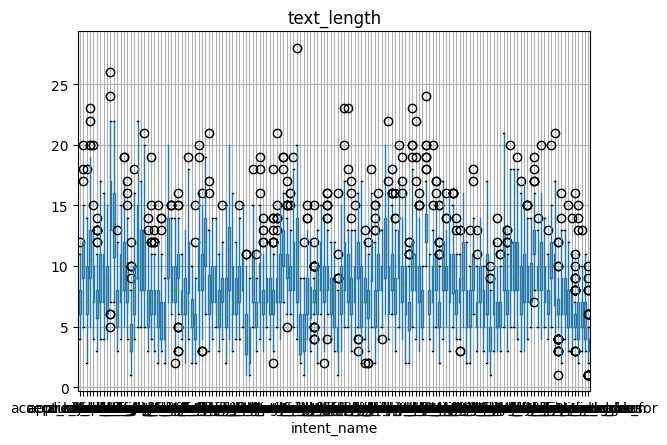

In [17]:
df.boxplot('text_length',by='intent_name')
plt.suptitle('')
plt.show()

The max length of the Sentences is around 28.

## Fine Tuning the Model

In [18]:
num_labels = clinc['train'].features['intent'].num_classes

# MODEL_NAME = "distilbert-base-uncased" # Any model from Hub or Pretrained Model Directory
MODEL_NAME = "distilroberta-base" # Any model from Hub or Pretrained Model Directory
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

In [19]:
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

clinc.reset_format()

In [20]:
clinc.rename_column_('intent','labels')

C:\Users\Subha\.conda\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.rename_column instead.
  """Entry point for launching an IPython kernel.


In [21]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5500
    })
})

In [22]:
# Tokenize using the DatasetDict features

clinc_encoded = clinc.map(tokenize,batched=True,batch_size=None)

100%|██████████| 1/1 [00:00<00:00,  6.94ba/s]


In [23]:
clinc_encoded['train'].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=151, names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined',

In [24]:
# Convert format to Torch Tensors for training the model

clinc_encoded.set_format('torch',columns=['input_ids','attention_mask','labels'])

In [25]:
clinc_encoded['train'][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
            47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1]),
 'labels': tensor(61)}

In [26]:
# Define Metrics

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    # wandb.log({"cm": wandb.sklearn.plot_confusion_matrix(labels, pred)})

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average="weighted")
    precision = precision_score(y_true=labels, y_pred=pred,average="weighted")
    f1 = f1_score(y_true=labels, y_pred=pred,average="weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [27]:
clinc_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 5500
    })
})

In [28]:
# Define Trainer
logging_steps = len(clinc_encoded['train']) // 32
# print(logging_steps)
wandb_run_name = "intent-detection-clinc"

args = TrainingArguments(
    report_to = 'wandb',  
    output_dir=f"results-{MODEL_NAME}",
    overwrite_output_dir = True,
    evaluation_strategy="steps",
    warmup_steps = 250,
    # label_smoothing_factor = 0.8,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    # save_strategy='epoch',
    save_steps=logging_steps*2,
    save_total_limit=3,
    seed=RANDOM_SEED,
    learning_rate=5e-5,
    fp16=True,
    weight_decay=0.01,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps = logging_steps,
    run_name = wandb_run_name
)

In [29]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=clinc_encoded['train'],
    eval_dataset=clinc_encoded['validation'],
    compute_metrics=compute_metrics
)

# Train pre-trained model
trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 15250
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1431
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


 33%|███▎      | 476/1431 [01:34<03:27,  4.61it/s]The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 32


{'loss': 3.1212, 'learning_rate': 4.0431837425910246e-05, 'epoch': 1.0}


C:\Users\Subha\.conda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 476/1431 [01:43<03:27,  4.61it/s]Saving model checkpoint to results-distilroberta-base\checkpoint-476
Configuration saved in results-distilroberta-base\checkpoint-476\config.json


{'eval_loss': 0.9546356201171875, 'eval_accuracy': 0.8735483870967742, 'eval_precision': 0.8822254746659711, 'eval_recall': 0.8735483870967742, 'eval_f1': 0.861583540856364, 'eval_runtime': 9.0125, 'eval_samples_per_second': 343.965, 'eval_steps_per_second': 10.763, 'epoch': 1.0}


Model weights saved in results-distilroberta-base\checkpoint-476\pytorch_model.bin
 67%|██████▋   | 952/1431 [03:19<01:51,  4.30it/s]The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 32


{'loss': 0.5259, 'learning_rate': 2.0321761219305676e-05, 'epoch': 2.0}



 67%|██████▋   | 952/1431 [03:27<01:51,  4.30it/s]Saving model checkpoint to results-distilroberta-base\checkpoint-952
Configuration saved in results-distilroberta-base\checkpoint-952\config.json


{'eval_loss': 0.3473324775695801, 'eval_accuracy': 0.9367741935483871, 'eval_precision': 0.9409859491790904, 'eval_recall': 0.9367741935483871, 'eval_f1': 0.9359085774733147, 'eval_runtime': 7.6477, 'eval_samples_per_second': 405.352, 'eval_steps_per_second': 12.684, 'epoch': 2.0}


Model weights saved in results-distilroberta-base\checkpoint-952\pytorch_model.bin
100%|█████████▉| 1428/1431 [04:53<00:00,  5.09it/s]The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 32



{'loss': 0.1822, 'learning_rate': 1.6934801016088062e-07, 'epoch': 2.99}



100%|█████████▉| 1428/1431 [05:01<00:00,  5.09it/s]Saving model checkpoint to results-distilroberta-base\checkpoint-1428
Configuration saved in results-distilroberta-base\checkpoint-1428\config.json


{'eval_loss': 0.2748606503009796, 'eval_accuracy': 0.9461290322580646, 'eval_precision': 0.9483805783330532, 'eval_recall': 0.9461290322580646, 'eval_f1': 0.9453642528474572, 'eval_runtime': 8.3574, 'eval_samples_per_second': 370.928, 'eval_steps_per_second': 11.606, 'epoch': 2.99}


Model weights saved in results-distilroberta-base\checkpoint-1428\pytorch_model.bin
100%|██████████| 1431/1431 [05:11<00:00,  2.75s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results-distilroberta-base\checkpoint-1428 (score: 0.9453642528474572).
100%|██████████| 1431/1431 [05:11<00:00,  4.59it/s]

{'train_runtime': 320.1713, 'train_samples_per_second': 142.892, 'train_steps_per_second': 4.469, 'train_loss': 1.2740163402404092, 'epoch': 3.0}


TrainOutput(global_step=1431, training_loss=1.2740163402404092, metrics={'train_runtime': 320.1713, 'train_samples_per_second': 142.892, 'train_steps_per_second': 4.469, 'train_loss': 1.2740163402404092, 'epoch': 3.0})

In [30]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 32
100%|██████████| 97/97 [00:09<00:00, 10.49it/s]


{'eval_loss': 0.2748606503009796,
 'eval_accuracy': 0.9461290322580646,
 'eval_precision': 0.9483805783330532,
 'eval_recall': 0.9461290322580646,
 'eval_f1': 0.9453642528474572,
 'eval_runtime': 9.361,
 'eval_samples_per_second': 331.16,
 'eval_steps_per_second': 10.362,
 'epoch': 3.0}

In [31]:
test_preds = trainer.predict(clinc_encoded['test'])

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 5500
  Batch size = 32
 99%|█████████▉| 171/172 [00:14<00:00, 12.23it/s]

In [32]:
test_preds.metrics

{'test_loss': 0.5878262519836426,
 'test_accuracy': 0.8858181818181818,
 'test_precision': 0.9022512278046637,
 'test_recall': 0.8858181818181818,
 'test_f1': 0.8798076120419426,
 'test_runtime': 14.6204,
 'test_samples_per_second': 376.187,
 'test_steps_per_second': 11.764}

In [33]:
labels = clinc_encoded['test'].features['labels'].names

In [34]:
def label_int2str(row,split):
    return clinc[split].features["labels"].int2str(row)

label_int2str(0,'test')

'restaurant_reviews'

In [35]:
from sklearn.metrics import classification_report

y_preds = np.argmax(test_preds.predictions,axis=1)
y_test = np.array(clinc_encoded['test']['labels'])

print(classification_report(y_test,y_preds,target_names=labels))

                           precision    recall  f1-score   support

       restaurant_reviews       0.91      0.97      0.94        30
           nutrition_info       0.88      1.00      0.94        30
          account_blocked       0.96      0.83      0.89        30
           oil_change_how       0.78      0.97      0.87        30
                     time       0.90      0.93      0.92        30
                  weather       0.67      1.00      0.80        30
           redeem_rewards       0.96      0.83      0.89        30
            interest_rate       0.85      0.97      0.91        30
                 gas_type       0.86      1.00      0.92        30
      accept_reservations       0.93      0.90      0.92        30
               smart_home       0.71      0.97      0.82        30
                user_name       0.94      0.97      0.95        30
         report_lost_card       0.93      0.90      0.92        30
                   repeat       0.97      0.97      0.97     

In [36]:
y_test = np.array(clinc_encoded['test']['labels'])
wandb.log({"test_set_cm": wandb.sklearn.plot_confusion_matrix(y_test, y_preds)})

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


In [37]:
wandb.finish()

eval/accuracy,0.94613
eval/f1,0.94536
eval/loss,0.27486
eval/precision,0.94838
eval/recall,0.94613
eval/runtime,9.361
eval/samples_per_second,331.16
eval/steps_per_second,10.362
train/epoch,3.0
train/global_step,1431
train/learning_rate,0.0


eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▂▁▁
eval/precision,▁▇██
eval/recall,▁▇██
eval/runtime,▇▁▄█
eval/samples_per_second,▂█▅▁
eval/steps_per_second,▂█▅▁
train/epoch,▁▁▅▅████
train/global_step,▁▁▄▄██████
train/learning_rate,█▅▁


## Save Model

In [38]:
MODEL_DIR = os.path.join('models',f'{MODEL_NAME}')

trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

Saving model checkpoint to models\distilroberta-base
Configuration saved in models\distilroberta-base\config.json
Model weights saved in models\distilroberta-base\pytorch_model.bin
tokenizer config file saved in models\distilroberta-base\tokenizer_config.json
Special tokens file saved in models\distilroberta-base\special_tokens_map.json


('models\\distilroberta-base\\tokenizer_config.json',
 'models\\distilroberta-base\\special_tokens_map.json',
 'models\\distilroberta-base\\vocab.json',
 'models\\distilroberta-base\\merges.txt',
 'models\\distilroberta-base\\added_tokens.json',
 'models\\distilroberta-base\\tokenizer.json')

100%|██████████| 172/172 [00:29<00:00, 12.23it/s]

## Infer with Pipeline

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to('cpu')
 
pipe = TextClassificationPipeline(model = model,tokenizer= tokenizer)

loading configuration file models\distilroberta-base\config.json
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": 

In [40]:
pipe('I need to book a cab to the airport')

[{'label': 'LABEL_39', 'score': 0.7054201364517212}]

In [52]:
train_dataset.features['intent'].int2str(39)

'uber'

## Check Metrics

### Size, Accuracy, Latency

In [60]:
intents.int2str(61)

'translate'

In [64]:
from pathlib import Path
from time import perf_counter

from datasets import load_metric
accuracy_score = load_metric('accuracy')

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"].split('_')[1]
            label = example["labels"]
            # preds.append(intents.str2int(pred))
            preds.append(pred)
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self,query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {self.optim_type: self.compute_size()}
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [65]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    plt.xlim(5, 53)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


In [66]:
### Benchmark the original Model pipeline

pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 313.75
Average latency (ms) - 31.52 +\- 18.03
Accuracy on test set - 0.886


In [41]:
from torch.quantization import quantize_dynamic

model_quantized = quantize_dynamic(model,{torch.nn.Linear},dtype=torch.qint8)


In [42]:
pipe_quantized = TextClassificationPipeline(model = model_quantized,tokenizer= tokenizer)
time_pipeline(pipe_quantized)

Average latency (ms) - 12.57 +\- 1.67


{'time_avg_ms': 12.573629000000892, 'time_std_ms': 1.6746370605120195}

100%|██████████| 172/172 [00:25<00:00, 14.18it/s]